In [1]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}
import matplotlib.pyplot as plt
import bqplot
import ipywidgets
import pandas as pd
from IPython.display import display, clear_output
import numpy as np
import os
from matplotlib import font_manager as fm
from matplotlib import cm
import matplotlib as mpl
import math
import traitlets
import re
from bqplot import *

In [2]:
# Set False to 'low_memory' due to the mix types
employee_df = pd.read_csv('dataset/survey_results_public.csv', low_memory=False)
schema_df = pd.read_csv('dataset/survey_results_schema.csv')

IOError: [Errno 2] File dataset/survey_results_public.csv does not exist: 'dataset/survey_results_public.csv'

## 1. Visualization of countries and programmer salaries.

In [ ]:
import csv
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import re
from scipy import stats
from forex_python.converter import CurrencyRates
from forex_python.bitcoin import BtcConverter
import datetime
from ipywidgets import interactive, interact
from ipywidgets import widgets
import mplcursors

In [ ]:
# Set False to 'low_memory' due to the mix types
employee_df = pd.read_csv('dataset/survey_results_public.csv', low_memory=False)
schema_df = pd.read_csv('dataset/survey_results_schema.csv')

# Currency exchange module
cr = CurrencyRates()
btc_conv = BtcConverter()
date_obj = datetime.datetime(2018, 1, 15)
USD_rates = cr.get_rates('USD', date_obj)

# Clean the commas in the columns
employee_df["Salary"].fillna(0, inplace=True)
employee_df["Salary"] = pd.to_numeric(employee_df["Salary"].apply(lambda x: re.sub(',', '', str(x))))
employee_df["SalaryType"].fillna('NULL', inplace=True)
employee_df['CurrencySymbol'].fillna('NULL', inplace=True)
employee_df["Salary"].astype('float32')
employee_df["ConvertedSalary"].fillna(0, inplace=True)
employee_df["ConvertedSalary"].astype('float32')

# Update the measurment of salaries to 'annual'

employee_df = employee_df[employee_df["Salary"] < 1e7]

for i, row in employee_df.iterrows():
    
    if row['SalaryType'] == 'Weekly':
        employee_df.at[i, 'Salary'] *= 52
    elif row['SalaryType'] == 'Monthly':
        employee_df.at[i, 'Salary'] *= 12
    elif row['SalaryType'] == 'NULL':
        employee_df.at[i, 'Salary'] = 0
    
    # Exchange all the salaries to US dollars
    if row['CurrencySymbol'] != 'USD' and row['CurrencySymbol'] != 'NULL':
        if row['CurrencySymbol'] in USD_rates:
            rate = USD_rates[row['CurrencySymbol']]
            converted_currency = row['Salary'] / rate
            employee_df.at[i, 'Salary'] = converted_currency
        else:
            employee_df.at[i, 'Salary'] = row['ConvertedSalary']

In [ ]:
employee_df = pd.read_csv('dataset/survey_results_public.csv', low_memory=False)
schema_df = pd.read_csv('dataset/survey_results_schema.csv')
employee_df["Salary"].fillna(0, inplace=True)
employee_df["ConvertedSalary"].fillna(0, inplace=True)
employee_df["ConvertedSalary"].astype('float32')

s_std = np.std(employee_df['ConvertedSalary'])
s_mean = np.mean(employee_df['ConvertedSalary'])

# Remove the outliers larger than or smaller than 3 sigma range
new_employee_df = employee_df[employee_df['ConvertedSalary'] > (s_mean - 3 * s_std)]
employee_df = new_employee_df[new_employee_df['ConvertedSalary'] < (s_mean + 3 * s_std)]
print("Mean: ", s_mean)
print("Std: ", s_std)

print(len(employee_df[employee_df['ConvertedSalary'] == 0]) / len(employee_df))

salary_df = employee_df[employee_df['ConvertedSalary'] > 0].groupby("Country")["ConvertedSalary"]
states = salary_df.describe()
states[:10]

In [3]:
states = salary_df.describe()
countries_shp = shpreader.natural_earth(resolution='110m', category='cultural', name='admin_0_countries')

def get_plot(states, term='mean', slider=None):
    plt.clf()
    # at least 10 Samples 
    states = states[states['count'] >= int(10)]
    
    max_mean_val = max(states[term])
    mean_val_list = states[term].tolist()
    country_name_list = list(states.index.values)

    # count the number of times a country is in the list
    # country_name_list = employee_df['Country'].unique().tolist()
    country_list = employee_df['Country'].tolist()
    unique_list = set(country_list)
    unique_list = list(unique_list)

    # ---- Graph
    cmap = mpl.cm.Blues
    count = 0
    
    ax = plt.axes(projection=ccrs.Robinson())
    fig = plt.gcf()
    mean_x_list, mean_y_list = [], []
    for country in shpreader.Reader(countries_shp).records():
        c_name = country.attributes['NAME_LONG']  
        this_geometry = [country.geometry]
        # If the country is in the list
        if c_name in country_name_list:
              
            i = country_name_list.index(c_name)
            # print(i, c_name)
            numero = mean_val_list[i]
            ax.add_geometries(this_geometry, ccrs.PlateCarree(),
                              facecolor=cmap(numero / float(max_mean_val), 1),
                              label=c_name)
            count += 1
        # Unknown country
        else:
            ax.add_geometries(this_geometry, ccrs.PlateCarree(),
                              facecolor='#DDDDDD',
                              label=c_name)
    
    clear_output()
    sm = plt.cm.ScalarMappable(cmap=cmap,norm=plt.Normalize(0,max_mean_val))
    sm._A = []
    plt.title('Countries and programmer annual '+ term +' salaries (USD)')
    # plt.show()

    fig.colorbar(sm,ax=ax)
    
    dpi = 80
    plt.rcParams["figure.figsize"] = (1000 / dpi, 600 / dpi)
    plt.rcParams['figure.dpi'] = dpi
    display(fig)
    # plt.show()
    print("Country count: ", count)
    print(country_name_list[mean_val_list.index(max_mean_val)])
    print("Maximum mean: ", max_mean_val)
    out = widgets.Output()
    clear_output()
    return out


# Dropdown
n_widget = ipywidgets.Dropdown(
                        options=['std', 'mean', '25%', '50%', '75%', 'max'],
                        value='mean',
                        description='Method:',
                        disabled=False,
                    )

def on_value_change(change):
    out = get_plot(states, term=n_widget.value)
    print("Mode: ", n_widget.value)
    print("Updating the figure...")
    print("This is the figure of " + str(n_widget.value) + " value of salaries in each country")
    display(ipywidgets.VBox([n_widget, out]))
    
n_widget.observe(on_value_change, names=['value'])

out = get_plot(states)
print("Mode: ", n_widget.value)
print("This is the figure of " + str(n_widget.value) + " value of salaries in each country")
display(ipywidgets.VBox([n_widget, out]))

NameError: name 'salary_df' is not defined

Before the visualization, the data itself requires lots of efforts to clean up and preprocessing. The procedure includes cleaning the NA values, exchange different currencies into US dollars as well as unify the 
'Weekly' and 'Monthly' paid salaries into 'annual' salaries.

This visualization is about the salaries of programmers in each country around the world. With the dropdown box listed, the user can select from the 6 options, namely 6 measurements to view the distributions of the salaries. Here, 'mean' represents the mean salary in each district, 'std' represents the standard deviation, which is a important aspect of fluctuation. Besides, '25%', '50%' and '75%' separately represent the quatile values, like '50%' represents the medium of the salary among the programmers. Overall, the demonstration is a heatmap with a color bar.

Mentioned by the graph, high averge salary countries are mainly in developed countries. Meanwhile, programmers in developing countries tends to have a lower avg. salary.

PS: The loading process will take about 10 seconds due to the huge amount of data.

PS2: Some countries will turn to grey (no data) since we filtered all the countries with less than 10 reviewers, which will helps to improve the stability.

## 2. Visualization of countries and programmer population.

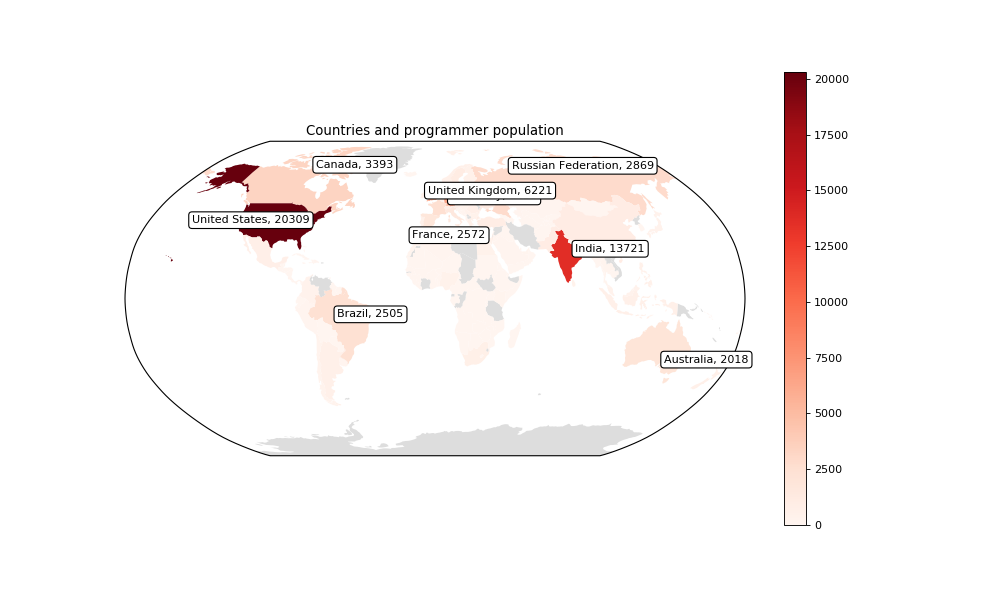

In [9]:
# Set False to 'low_memory' due to the mix types
employee_df = pd.read_csv('dataset/survey_results_public.csv', low_memory=False)
schema_df = pd.read_csv('dataset/survey_results_schema.csv')

sort_salary_df = employee_df.groupby("Country")['Salary']
sort_states = sort_salary_df.describe()
sort_states = sort_states.sort_values('count', ascending=False)

num_sort_states = sort_states[:10]
display_country_list = list(num_sort_states.index.values)

#count the number of times a country is in the list
country_name_list = employee_df['Country'].unique().tolist()
country_list = employee_df['Country'].tolist()
unique_list = set(country_list)
unique_list = list(unique_list)

popu_count = []

for p in unique_list:
    popu_count.append(country_list.count(p))
    # print(p, country_list.count(p))

maximo = max(popu_count)

cmap = mpl.cm.Reds

countries_shp = 0
countries_shp = shpreader.natural_earth(resolution='110m',
                                        category='cultural', name='admin_0_countries')

count = 0
ax = plt.axes(projection=ccrs.Robinson())

label_count = 0
label_max = 10
for country in shpreader.Reader(countries_shp).records():
    # print(country.attributes)
    c_name = country.attributes['NAME_LONG']  
    # If the country is in the list
    
    # print(country)
    this_geometry = [country.geometry]
    
    if c_name in unique_list:
        i = unique_list.index(c_name)
        numero = popu_count[i]
        if label_count < label_max and c_name in display_country_list:
            # -------- Labels of country
            try:
                polys = list(country.geometry)
            except:
                polys = list([country.geometry])
            # print(len(polys))
            mean_x, mean_y = [], []
            for poly in polys:
                x, y = poly.exterior.coords.xy
                mean_x.append(np.mean(x))
                mean_y.append(np.mean(y))
            x_val = np.mean(mean_x)
            y_val = np.mean(mean_y)
            # sc = ax.scatter(mean_x, mean_y, c=0, transform=ccrs.PlateCarree())

            #print(x_val, y_val)

            annot = ax.annotate("{}, {}".format(c_name, numero), xy=(x_val, y_val),
                                xycoords=ccrs.PlateCarree()._as_mpl_transform(ax),
                                bbox=dict(boxstyle="round", fc="w"),
                                arrowprops=dict(arrowstyle="->"), picker=8)
            
            annot.set_visible(True)

            label_count += 1
            # ------ End of labels
        
        ax.add_geometries(this_geometry, ccrs.PlateCarree(),
                          facecolor=cmap(numero / float(maximo), 1),
                          label=c_name)
        count += 1
    # Unknown country
    else: 
        ax.add_geometries(this_geometry, ccrs.PlateCarree(),
                          facecolor='#DDDDDD',
                          label=c_name)
#print("Country count: ", count)

sm = plt.cm.ScalarMappable(cmap=cmap,norm=plt.Normalize(0,maximo))
sm._A = []
plt.colorbar(sm, ax=ax)
dpi = 120
plt.rcParams["figure.figsize"] = (800 / dpi, 600 / dpi)
plt.rcParams['figure.dpi'] = dpi
plt.title('Countries and programmer population')

def onhover(event):
    #print(event)
    event.artist.set_visible(False)
    
    fig.canvas.draw()
    plt.show()
  
#fig = plt.gcf()
#fig.canvas.mpl_connect('pick_event', onhover)

plt.show()

This visualization mainly about the overall population distribution of the users around the world. Based on the number of interviewees of the questionaire, also combined with the visualization above, we may conclude that it is unecessarily the population of programmers has a firm connection with the average salaries in the world. For example, in Brazil, with relatively huge amount of progrmmers (top 10 in the people finishing this questionaire), their average salary are not satisfying compared to other developed countries.

## 3. Visualization of countries and open source

In [4]:
file_path = "survey_results_public.csv"
df = pd.read_csv(file_path)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (8,12,13,14,15,16,50,51,52,53,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
new_country_openSource = df[["Country", "OpenSource"]]
new_country_openSource.dropna(axis=0,how='all')

,Country,OpenSource
0,Kenya,No
1,United Kingdom,Yes
2,United States,Yes
3,United States,No
4,South Africa,No
5,United Kingdom,No
6,United States,Yes
7,Nigeria,Yes
8,United States,Yes
9,India,Yes


In [6]:
openSource_country = {}
openSource_country["Yes"] = []
openSource_country["No"] = []

for row in range(len(new_country_openSource)):
    open_source = new_country_openSource["OpenSource"][row]
    country = new_country_openSource["Country"][row]
    
    if open_source == "Yes":
        openSource_country["Yes"].append(country)
    else:
        openSource_country["No"].append(country)

In [7]:
def pie_chart_helper(country):
    country_count = {}
    
    for each in country:
        if each in country_count:
            country_count[each] = country_count[each] + 1
        else:
            country_count[each] = 1
    
    countries = []
    count = []
    
    for key in country_count:
        if isinstance(key, str):
            countries.append(str(key).decode('utf-8'))
            count.append(country_count[key])
        
    return countries, count

In [8]:
yes_countries, yes_count = pie_chart_helper(openSource_country["Yes"])
no_countries, no_count = pie_chart_helper(openSource_country["No"])

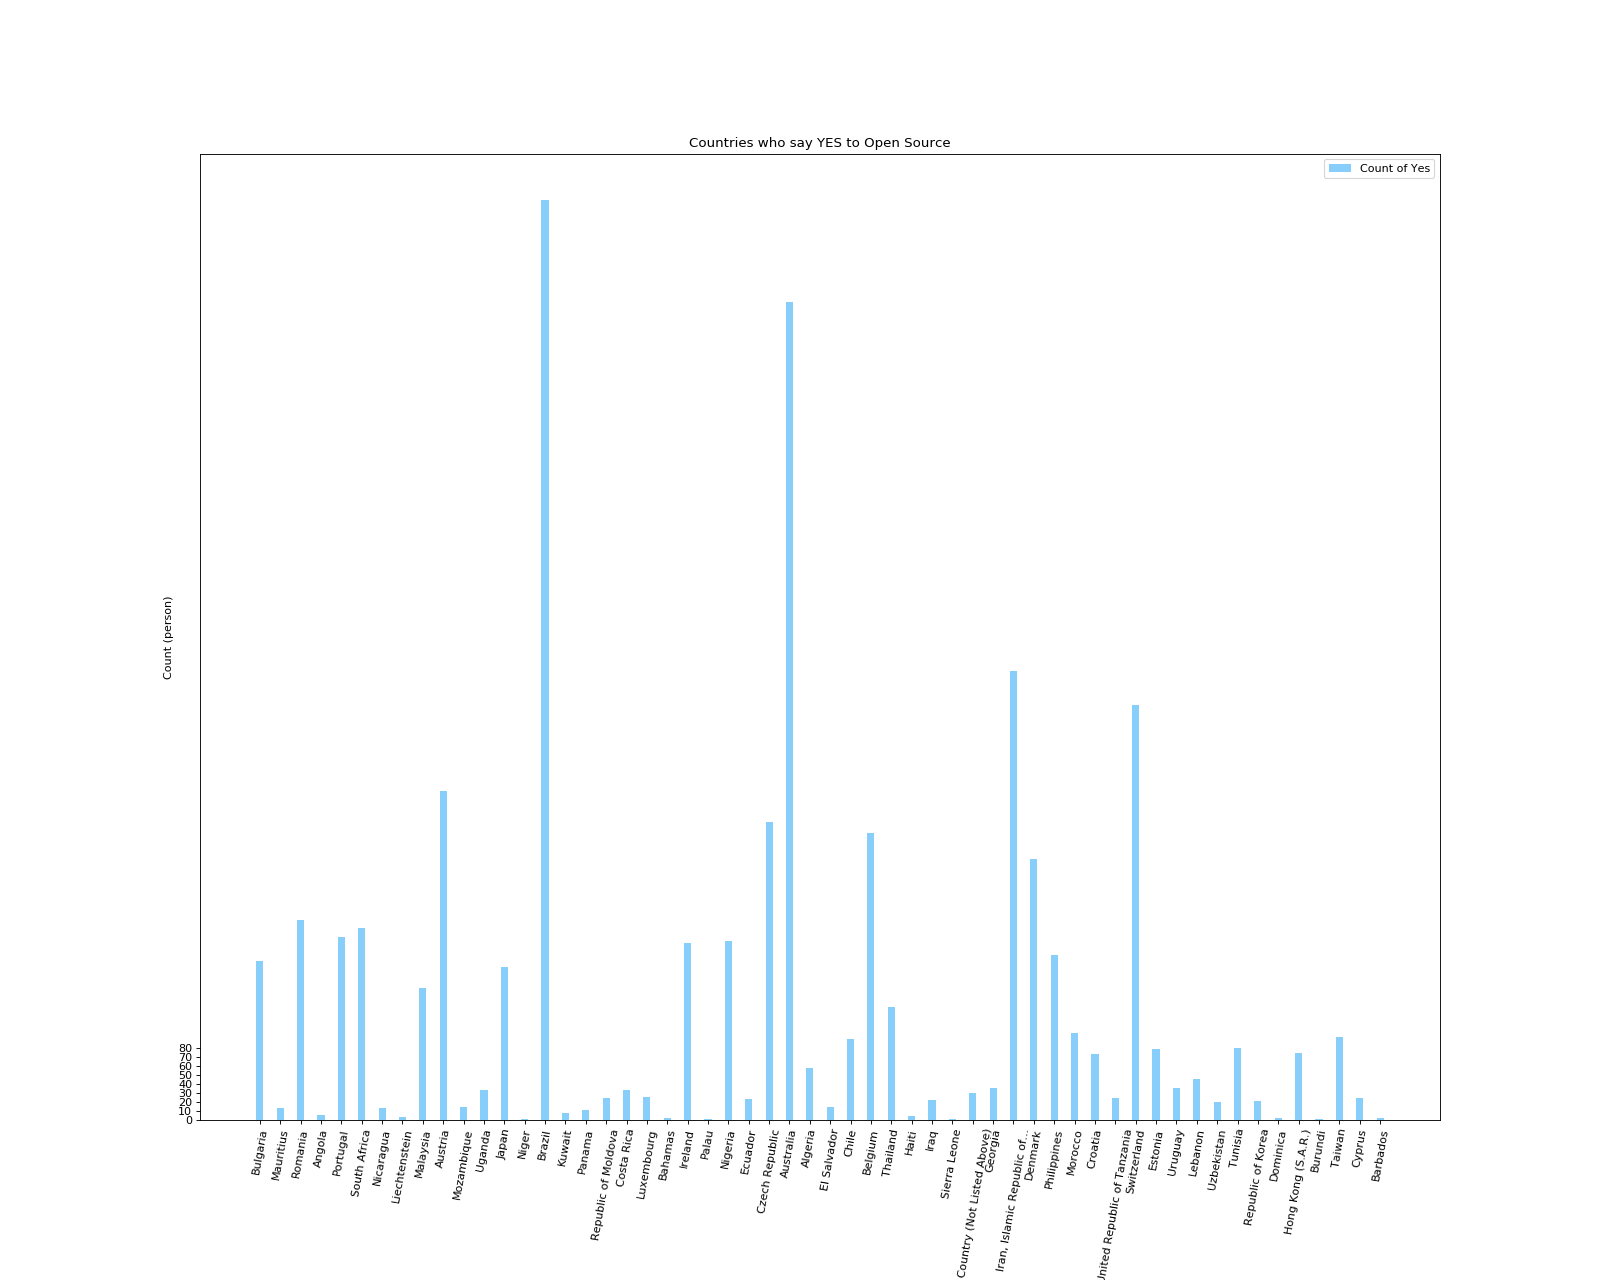

In [9]:
countries = yes_countries[72:128]
count = yes_count[72:128]

plt.figure(figsize=(20, 16), dpi = 80)

plt.subplot(1, 1, 1)

N = len(countries)
values = count
index = np.arange(N)
width = 0.35
p2 = plt.bar(index, values, width, label="Count of Yes", color="#87CEFA")

plt.xlabel('Country')
plt.ylabel('Count (person)')

plt.title('Countries who say YES to Open Source')

plt.xticks(index, countries)
plt.xticks(rotation=80)
plt.yticks(np.arange(0, 81, 10))
plt.legend(loc="upper right")

plt.show()

This is a bar chart, which refers to the number of people from different countries who work with open source.

This figure refers to the data visualization of the relationship between country and open source. According to the survey, the interviewee comes from different countries, and they have an open-source work background. In this way, this piece of data visualization can be analyzed based on this result. Different people are group by country and summarize the open-source opinion. 

This data visualization is a bar chart, and the number of the result is limited due to the large scale of data set. Through this data visualization, we can see the comparison between different countries and the specific number of people in a specific country.

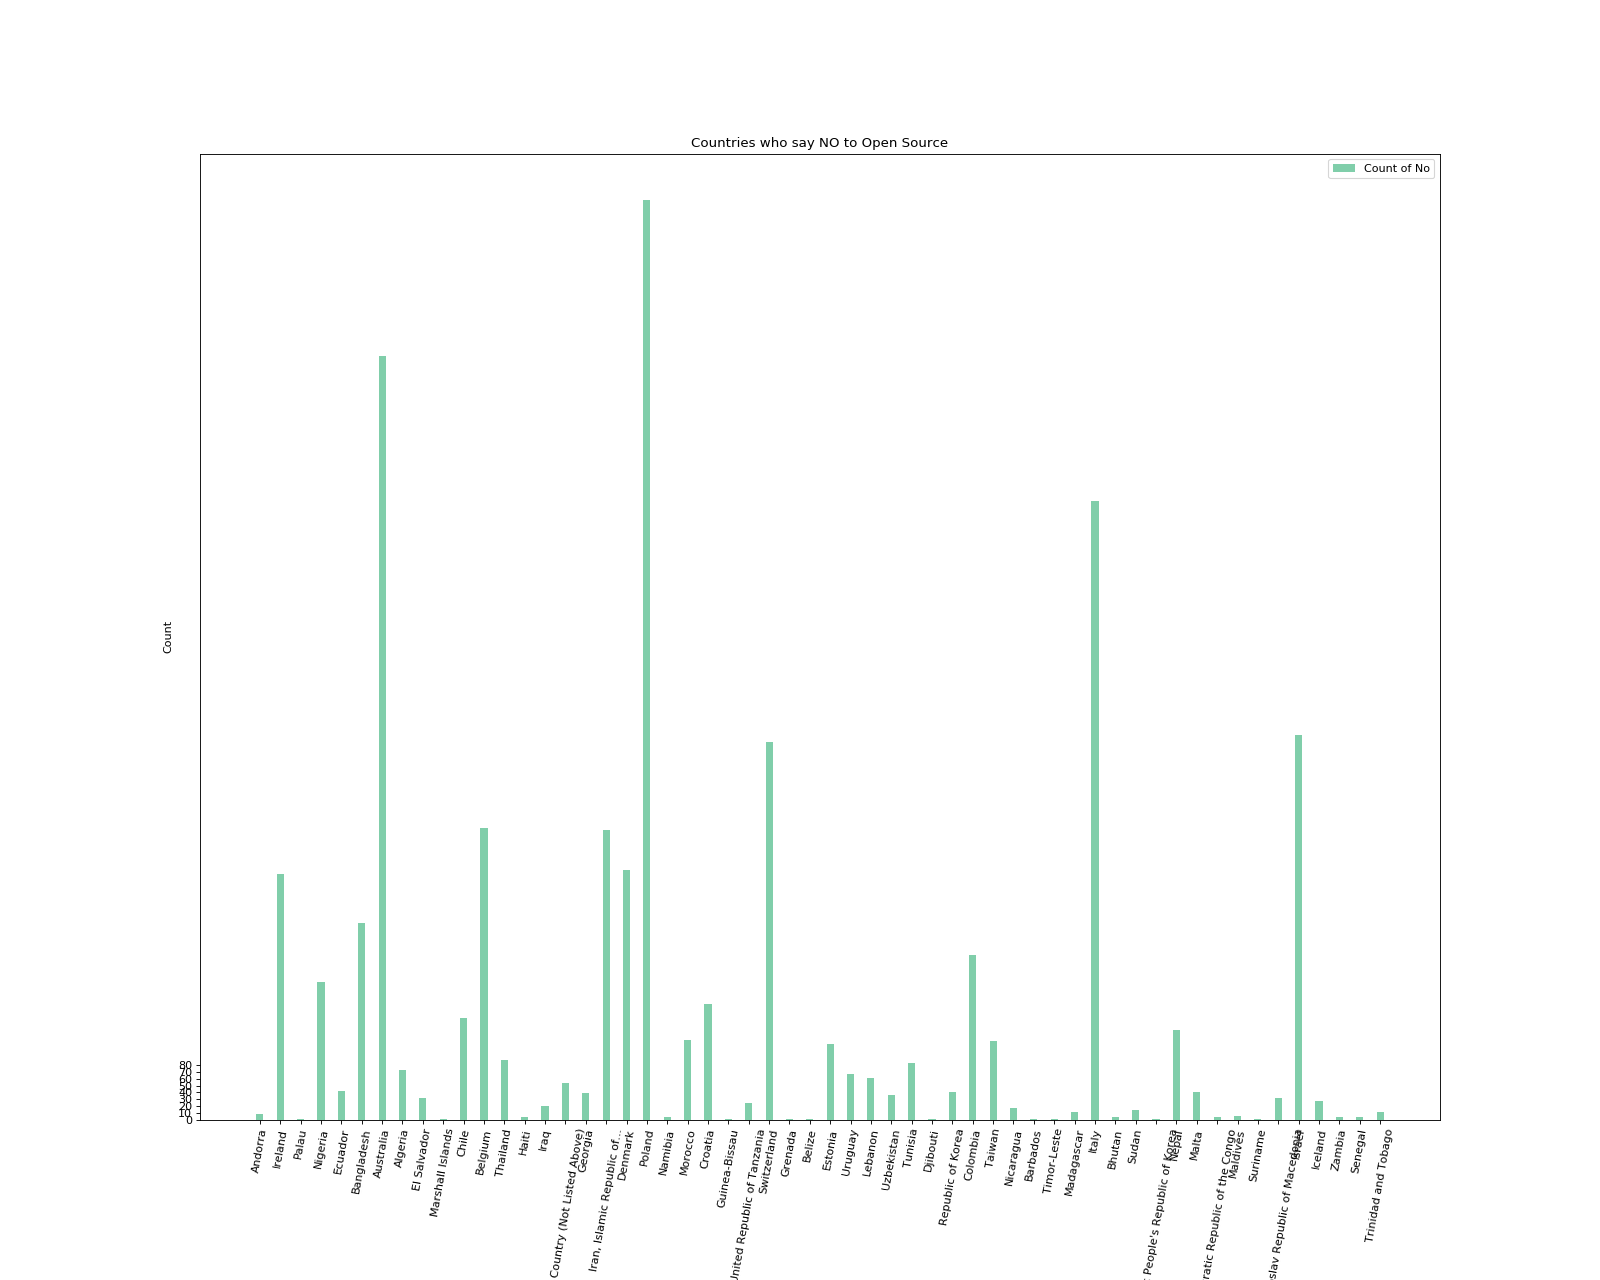

In [10]:
countries = no_countries[98:154]
count = no_count[98:154]

plt.figure(figsize=(20, 16), dpi = 80)

plt.subplot(1, 1, 1)

N = len(countries)
values = count
index = np.arange(N)
width = 0.35
p2 = plt.bar(index, values, width, label="Count of No", color="#80CEAA")

plt.xlabel('Country')
plt.ylabel('Count')

plt.title('Countries who say NO to Open Source')

plt.xticks(index, countries)
plt.xticks(rotation=80)
plt.yticks(np.arange(0, 81, 10))
plt.legend(loc="upper right")

plt.show()

This is a bar chart, which refers to the number of people from different countries who don't work with open source.

## 4. Visualization of company size

In [11]:
new_company_size = df[["CompanySize"]]
new_company_size.dropna(axis=0,how='all')

,CompanySize
0,20 to 99 employees
1,"10,000 or more employees"
2,20 to 99 employees
3,100 to 499 employees
4,"10,000 or more employees"
5,10 to 19 employees
6,"10,000 or more employees"
7,10 to 19 employees
8,100 to 499 employees
9,500 to 999 employees


In [12]:
size_count = {}

for index in range(len(new_company_size)):
    size = str(new_company_size["CompanySize"][index])
    if size != 'nan':
        if size in size_count:
            size_count[size] = size_count[size] + 1
        else:
            size_count[size] = 1

In [13]:
categories = size_count.keys()
proportion = size_count.values()

In [14]:
drpbx = ipywidgets.Dropdown(options=[(2), (4), (6), (8)], index=1, label="4")

def draw():
    choice = int(drpbx.label)

    colors = ['red','yellowgreen','lightskyblue','yellow', 'pink', 'salmon', 'gold', 'thistle']
    margin = {}
    margin["top"] = 0
    margin["bottom"] = 20
    margin["left"] = 0
    margin["right"] = 0
    pie = Pie(sizes=[], select_slices=True, opacities=[0.2], colors=colors[:choice], sort=True, display_labels="outside")
    pie_fig = Figure(marks=[pie], title="The Proportion of Company Size in the Country Level"
                     , fig_margin=margin)
    pie.sizes = proportion[:choice]
    pie.labels = categories[:choice]

    display(pie_fig)

def chosen(_):
    draw()

vbox = ipywidgets.VBox([ipywidgets.Label("Please choose the number of Categories to display"), drpbx])
display(vbox)
draw()
drpbx.observe(chosen, names = "value")

VkJveChjaGlsZHJlbj0oTGFiZWwodmFsdWU9dSdQbGVhc2UgY2hvb3NlIHRoZSBudW1iZXIgb2YgQ2F0ZWdvcmllcyB0byBkaXNwbGF5JyksIERyb3Bkb3duKGluZGV4PTEsIG9wdGlvbnM9KDLigKY=


RmlndXJlKGZpZ19tYXJnaW49eyd0b3AnOiAwLCAnbGVmdCc6IDAsICdyaWdodCc6IDAsICdib3R0b20nOiAyMH0sIG1hcmtzPVtQaWUoY29sb3JzPVsncmVkJywgJ3llbGxvd2dyZWVuJywgJ2zigKY=


This is an interactive pie chart, which refers to the company size in the world level. Data visualization does not consider the country level, and only consider the company size and corresponding proportion.

There are eight kinds of classifications on the company size, namely less than 10, 10-19, 20-99, 100-499, 500-999, 1000-4999, 5000-9999 and more than 10000. In order to display the proportion of different sections, the number of kinds of company size can be set manually, namely 4, 6, and 8.

According to this data visualization, we can see the relative proportion among company sizes. 